<a href="https://colab.research.google.com/github/AnnweshaAdhikari/Parkinson-Disease-Prediction/blob/main/Parkinson_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary libraries including Pandas, XGBoost, IMblearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

### Data from https://www.kaggle.com/datasets/dipayanbiswas/parkinsons-disease-speech-signal-features?resource=download

In [ ]:
dataframe = pd.read_csv('/content/pd_speech_features.csv')
dataframe.shape

(756, 755)

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [ ]:
dataframe.describe()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,...,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110,0.746032
std,72.793721,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,...,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,0.000011,0.000210,...,1.509800,1.531700,1.582900,1.747200,1.789500,1.628700,1.861700,1.955900,2.364000,0.000000
25%,62.750000,0.000000,0.762833,0.647053,0.386537,251.000000,250.000000,0.005003,0.000049,0.000970,...,2.408675,3.452800,3.354825,3.077450,2.937025,3.114375,3.665925,3.741275,3.948750,0.000000
50%,125.500000,1.000000,0.809655,0.700525,0.484355,317.000000,316.000000,0.006048,0.000077,0.001495,...,5.586300,7.062750,6.077400,4.770850,4.300450,4.741450,6.725700,7.334250,10.637250,1.000000
75%,188.250000,1.000000,0.834315,0.754985,0.586515,384.250000,383.250000,0.007528,0.000171,0.002520,...,28.958075,29.830850,21.944050,13.188000,10.876150,12.201325,21.922050,22.495175,61.125325,1.000000
max,251.000000,1.000000,0.907660,0.852640,0.871230,907.000000,905.000000,0.012966,0.003483,0.027750,...,239.788800,203.311300,121.542900,102.207000,85.571700,73.532200,62.007300,57.544300,156.423700,1.000000


## Data cleaning and pre-processing

In [ ]:
dataframe = dataframe.groupby('id').mean().reset_index()
dataframe.drop('id', axis=1, inplace=True)

In [ ]:
columns = list(dataframe.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in dataframe.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = dataframe[col].corr(dataframe[col1])

        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)

    # After each iteration filter out the columns
    # which are not highly correlated features.
    dataframe = dataframe[filtered_columns]
dataframe.shape

(252, 287)

In [ ]:
X = dataframe.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, dataframe['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = dataframe['class']
dataframe = filtered_data
dataframe.shape

(252, 31)

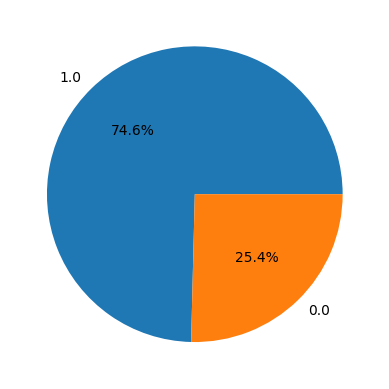

In [ ]:
x = dataframe['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

## Model training

In [ ]:
features = dataframe.drop('class', axis=1)
target = dataframe['class']

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)
X_train.shape, X_val.shape

((201, 30), (51, 30))

In [ ]:
# As the data was highly imbalanced we will balance
#  it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=42)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.shape

((302, 30), (302,))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score as ras

models = [
    LogisticRegression(),
    XGBClassifier(),
    SVC(kernel='rbf', probability=True),
    RandomForestClassifier(),
    GaussianNB()
]

# Training and evaluating each model
for model in models:
    model.fit(X, Y)

    print(f'{model.__class__.__name__} : ')

    train_preds = model.predict_proba(X)[:, 1]
    print('Training AUC: ', ras(Y, train_preds))

    val_preds = model.predict_proba(X_val)[:, 1]
    print('Validation AUC: ', ras(Y_val, val_preds))
    print()

LogisticRegression : 
Training AUC:  0.8403578790403929
Validation AUC:  0.8378378378378378

XGBClassifier : 
Training AUC:  1.0
Validation AUC:  0.8223938223938224

SVC : 
Training AUC:  0.6978202710407437
Validation AUC:  0.752895752895753

RandomForestClassifier : 
Training AUC:  1.0
Validation AUC:  0.8117760617760618

GaussianNB : 
Training AUC:  0.8352703828779439
Validation AUC:  0.8050193050193051



## Model evaluation

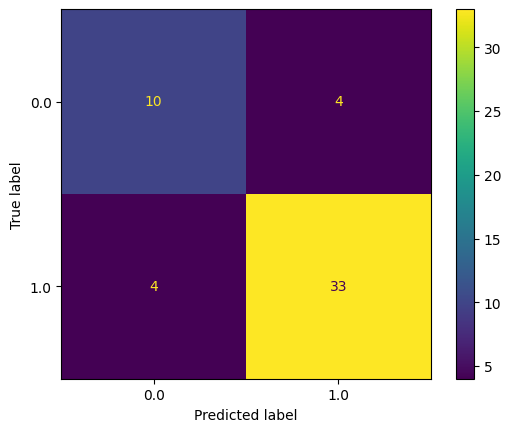

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_val, Y_val)

plt.show()

In [ ]:
print(metrics.classification_report
      (Y_val, models[0].predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71        14
         1.0       0.89      0.89      0.89        37

    accuracy                           0.84        51
   macro avg       0.80      0.80      0.80        51
weighted avg       0.84      0.84      0.84        51

